In [61]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

1. Load and preprocess both images:
    - Convert to grayscale (if needed)
    - Resize (optional)

2. calculate key points using harris detector
    - this is redundent if using SIFT, use for ORB

3. Detect and extract SIFT features from both images:
    - Keypoints_target, Descriptors_target = SIFT_Detector(target_image)
    - Keypoints_reference, Descriptors_reference = SIFT_Detector(reference_image)

4. Match SIFT features using Brute-Force (BF) Matcher:
    - Matches = Match_Features(Descriptors_target, Descriptors_reference)

5. Apply RANSAC to filter outliers:
    - Extract corresponding keypoints from matches
    - Compute homography matrix using RANSAC
    - Warp target image using homography

6. Apply Phase Correlation for fine-tuned alignment:
    - Convert target and reference images to the frequency domain (Fourier Transform)
    - Compute cross-power spectrum
    - Find peak shift to estimate translation
    - Refine final translation based on phase correlation

7. Compute final displacement vector:
    - Combine homography translation (RANSAC) and fine-tuned translation (Phase Correlation)

8. Output the final displacement results and visualize:
    - Print displacement (dx, dy)
    - Display feature matches and registered images


### Load & Preprocess Images
- convert images to greyscale to make sift and harris work better because works better with single channel
- resize images for optimization

In [75]:
# Constants
REFFERENCE_IMAGE_PATH = 'earth_img\photo_093_53244355532_o.jpg'
#TRANSLATED_IMAGE_PATH = 'earth_img\photo_083_53245728645_o.jpg' # completely different image
#TRANSLATED_IMAGE_PATH = 'earth_img\photo_093_53244355532_o.jpg' # same as REFFERENCE_IMAGE_PATH
TRANSLATED_IMAGE_PATH = 'earth_img\photo_094_53245597269_o.jpg' # more slightly different image
#'earth_img\photo_092_53245529093_o.jpg' # slightly different image
SCALE_FACTOR = 0.5

In [63]:
def preprocess_image(image_path: str, scale_factor: float = 1.0):
    """
    Load and preprocess an image (resize, convert to grayscale, and return in uint8 format).
    """
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    image_resized = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    return image_gray  # Keep as uint8

In [76]:
reference_image_gray = preprocess_image(REFFERENCE_IMAGE_PATH, SCALE_FACTOR)
translated_image_gray = preprocess_image(TRANSLATED_IMAGE_PATH, SCALE_FACTOR)

### Harris Detector
- use opencv harris corner detector to return a list of keypoints
- this is redundent if using sift, but useful in case of using ORB

In [65]:
def detect_harris_corners(image: np.ndarray):
    """
    Detect Harris corners and return them as keypoints.
    """
    corners = cv2.cornerHarris(image, 2, 3, 0.04)
    corners = cv2.dilate(corners, None)
    keypoints = [cv2.KeyPoint(float(x[1]), float(x[0]), 20) for x in np.argwhere(corners > 0.01 * corners.max())]
    return keypoints


### SIFT Feature Extraction
- Detect keypoints and compute descriptors using SIFT.
- Keypoints contain locations, and descriptors contain feature vectors.

In [66]:
def SIFT_keypoints(image: np.ndarray):
    """
    Detect SIFT keypoints and return them.
    """
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

### Feature matching
- Brute-Force Mathcer (cv2.BFMatcher) to find strongest matches between descriptors
- sort matches based on feature distance

In [67]:
def match_keypoints(descriptors1, descriptors2):
    """
    Match keypoints from two images.
    """
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    return good_matches

### RANSAC for Outlier Removal
- Extract corresponding matched keypoints.
- Estimate a homography matrix using RANSAC (cv2.findHomography).
- Warp the target image using the homography to align it with the reference. (skip for now)

In [68]:
def remove_outliers_ransac(keypoints1, keypoints2, matches):
    """
    Remove outliers using RANSAC.
    """
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()
    inliers = [m for i, m in enumerate(matches) if matches_mask[i]]
    return inliers#, M, matches_mask 

# warp for homography
# def warp_image(image1, image2, homography):
#     """
#     Warp image1 using homography to align with image2.
#     """
#     h, w = image1.shape
#     image1_warped = cv2.warpPerspective(image1, homography, (w, h))
#     return image1_warped

### Apply Phase Correlation for fine-tuned alignment:
>copied from chat gpt, I have no idea how to do phase correlation
    - Convert target and reference images to the frequency domain (Fourier Transform)
    - Compute cross-power spectrum
    - Find peak shift to estimate translation
    - Refine final translation based on phase correlation

In [78]:
def phase_correlation(a, b):
    """
    Perform phase correlation to compute the global displacement (translation) between two images (greyscale).
    Returns (dx, dy): translation in x and y directions.
    """
    
    # Perform phase correlation
    G_a = np.fft.fft2(a)
    G_b = np.fft.fft2(b)
    
    conj_b = np.ma.conjugate(G_b)
    R = G_a*conj_b
    R /= np.absolute(R)
    r = np.fft.ifft2(R).real
    return r
    # print(r)
    # # convert to pixel coordinates
    # h, w = r.shape
    # x = np.arange(w)
    # y = np.arange(h)
    # x, y = np.meshgrid(x, y)
    # x -= w//2
    # y -= h//2

    # # find peak
    # peak = np.unravel_index(np.argmax(r), r.shape)
    # dx, dy = peak[1], peak[0]

    # # visualize shift
    # plt.imshow(r, cmap='gray')
    # plt.colorbar()
    # plt.scatter(peak[1], peak[0], color='red')
    # plt.title(f"Peak at ({dx}, {dy})")
    # plt.show()
    # return dx, dy

Note: you may need to restart the kernel to use updated packages.
[0. 0.] 1.0 7.736245970277833e-18


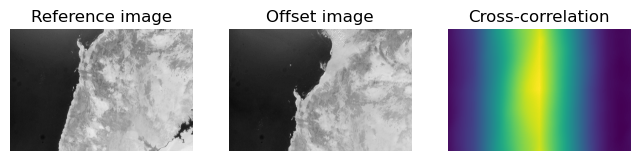

Detected pixel offset (y, x): [0. 0.]


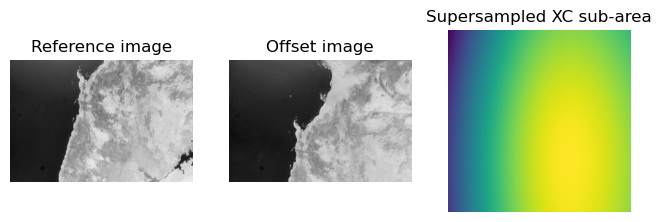

Detected subpixel offset (y, x): [-0.01  0.  ]


In [122]:
%pip install scikit-image

import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation as register_translation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

# image = data.camera()
# shift = (-22.4, 13.32)
# The shift corresponds to the pixel offset relative to the reference image
# offset_image = fourier_shift(np.fft.fftn(image), shift)
# offset_image = np.fft.ifftn(offset_image)

# im1 = cv2.imread('earth_img\photo_111_53245235266_o.jpg', cv2.IMREAD_GRAYSCALE)

# im2 = cv2.imread('earth_img\photo_112_53245235261_o.jpg', cv2.IMREAD_GRAYSCALE)

im1  = cv2.imread('earth_img\photo_093_53244355532_o.jpg', cv2.IMREAD_GRAYSCALE)
im2  = cv2.imread('earth_img\photo_094_53245597269_o.jpg', cv2.IMREAD_GRAYSCALE)

# im1 = cv2.resize(im1, (0,0), fx=0.039, fy=0.039)
# im2 = cv2.resize(im2, (0,0), fx=0.039, fy=0.039)

h, w = 2000,3000

center = im1.shape
x = center[1]/2 - w//2
y = center[0]/2 - h//2

crop_img1 = im1[int(y):int(y+h), int(x):int(x+w)]

crop_img2 = im2[int(y):int(y+h), int(x):int(x+w)]

image = crop_img1
offset_image = crop_img2
# shift = (-22.4, 13.32)
# #The shift corresponds to the pixel offset relative to the reference image
# offset_image = fourier_shift(np.fft.fftn(image), shift)
# offset_image = np.fft.ifftn(offset_image)



#print("Known offset (y, x): {}".format(shift))

# pixel precision first
shift, error, diffphase = register_translation(image, offset_image)

print(shift, error, diffphase)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1, adjustable='box')
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1, adjustable='box')
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print("Detected pixel offset (y, x): {}".format(shift))

# subpixel precision
shift, error, diffphase = register_translation(image, offset_image, upsample_factor=100)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1, adjustable='box')
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1, adjustable='box')
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print("Detected subpixel offset (y, x): {}".format(shift))

In [ ]:
def draw_matches(image1, keypoints1, image2, keypoints2, matches):
    """
    Draw matches between two images.
    """
    image_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None)
    return image_matches

def draw_keypoints(image, keypoints):
    """
    Draw keypoints on an image.
    """
    image_keypoints = cv2.drawKeypoints(image, keypoints, None)
    return image_keypoints

def draw_inliers(image1, keypoints1, image2, keypoints2, inliers):
    """
    Draw inliers between two images.
    """
    image_inliers = cv2.drawMatches(image1, keypoints1, image2, keypoints2, inliers, None)
    return image_inliers

def main():
    keypoints1 = detect_harris_corners(reference_image_gray)
    keypoints2 = detect_harris_corners(translated_image_gray)
    keypoints1, descriptors1 = SIFT_keypoints(reference_image_gray)
    keypoints2, descriptors2 = SIFT_keypoints(translated_image_gray)
    matches = match_keypoints(descriptors1, descriptors2)
    inliers, displacement_vectors = remove_outliers_ransac(keypoints1, keypoints2, matches, reference_image_gray, translated_image_gray)

    # calculate displacement using phase correlation and inliers
    

    image_matches = draw_matches(reference_image_gray, keypoints1, translated_image_gray, keypoints2, matches)
    image_inliers = draw_inliers(reference_image_gray, keypoints1, translated_image_gray, keypoints2, inliers)
    image_keypoints1 = draw_keypoints(reference_image_gray, keypoints1)
    image_keypoints2 = draw_keypoints(translated_image_gray, keypoints2)
    
    print(f"Displacement: {displacement}")
    
    plt.figure(figsize=(20, 10))
    plt.subplot(231), plt.imshow(reference_image_gray, cmap='gray'), plt.title('Reference Image')
    plt.subplot(232), plt.imshow(translated_image_gray, cmap='gray'), plt.title('Translated Image')
    plt.subplot(233), plt.imshow(image_matches), plt.title('Matches')
    plt.subplot(234), plt.imshow(image_inliers), plt.title('Inliers')
    plt.subplot(235), plt.imshow(image_keypoints1), plt.title('Reference Image Keypoints')
    plt.subplot(236), plt.imshow(image_keypoints2), plt.title('Translated Image Keypoints')
    plt.show()

reference_image_gray = preprocess_image(REFFERENCE_IMAGE_PATH, SCALE_FACTOR)
translated_image_gray = preprocess_image(TRANSLATED_IMAGE_PATH, SCALE_FACTOR)

main()

[[ 1.00000000e+00 -2.35971333e-21  2.80210610e-21 ...  1.05294311e-20
  -1.61950493e-20  2.08219343e-21]
 [ 8.25090696e-21  1.86451877e-20 -1.32681201e-20 ...  1.85769477e-20
   1.92523173e-21  1.21659652e-20]
 [ 2.32264872e-21  2.59951944e-20  1.40560037e-21 ... -1.35086352e-20
  -1.02116520e-20  8.75785062e-21]
 ...
 [-4.57186906e-21 -4.90450007e-21 -3.17132118e-21 ... -9.15799977e-21
  -1.79089611e-22 -7.82837502e-21]
 [-2.32264872e-21  2.41521062e-20 -2.23182256e-20 ... -1.62682324e-20
  -6.76094752e-21  8.67423888e-22]
 [-8.25090696e-21  2.74666477e-20 -1.77286157e-20 ...  8.83680935e-23
   1.10198499e-20  4.32979656e-21]]
Global Translation (Phase Correlation): dx=0, dy=0
Displacement: [  36.1786759  -411.22903106]


0 0


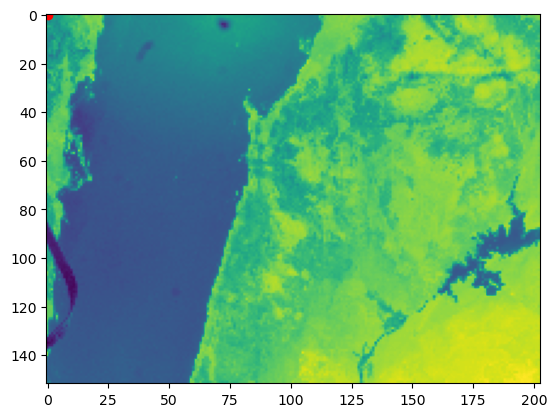

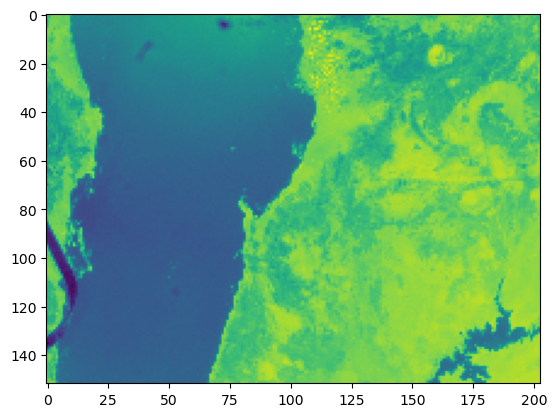

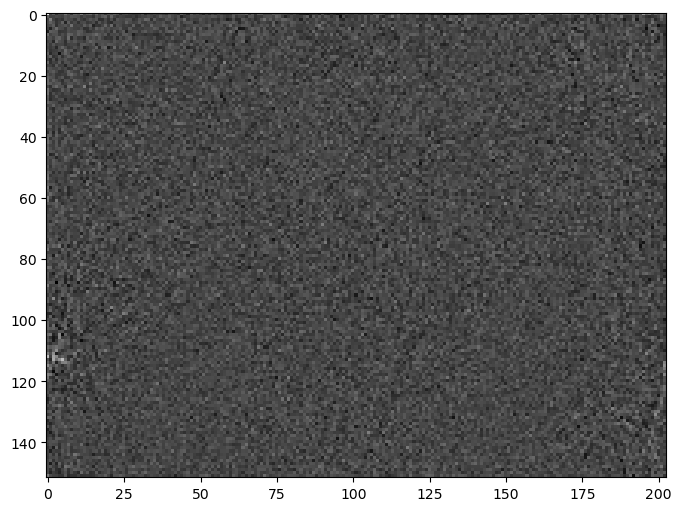

In [102]:
from scipy import misc
from matplotlib import pyplot
import numpy as np

#Get two images with snippet at different locations
#im1 = np.mean(misc.face(), axis=-1) #naive colour flattening  

im1 = cv2.imread('earth_img\photo_093_53244355532_o.jpg', cv2.IMREAD_GRAYSCALE)

im2 = cv2.imread(TRANSLATED_IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

im1 = cv2.resize(im1, (0,0), fx=0.05, fy=0.05)
im2 = cv2.resize(im2, (0,0), fx=0.05, fy=0.05)

corrimg = phase_correlation(im1, im2)
r,c = np.unravel_index(corrimg.argmax(), corrimg.shape)

print(r,c)

%matplotlib inline 

pyplot.imshow(im1)
pyplot.plot([c],[r],'ro')
pyplot.show()

pyplot.imshow(im2)
pyplot.show()

pyplot.figure(figsize=[8,8])
pyplot.imshow(corrimg, cmap='gray')

pyplot.show()

In [124]:
def remove_outliers_ransac(keypoints1, keypoints2, matches, img1, img2):
    """
    Remove outliers using RANSAC.
    """
    # Step 1: Convert keypoints to points (x, y)
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    # Step 2: Use RANSAC to estimate the homography and filter out outliers
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()
    
    # Filter matches based on RANSAC mask (1 = inlier, 0 = outlier)
    inliers = [m for i, m in enumerate(matches) if matches_mask[i]]
    
    # Step 3: Compute displacement vectors for inliers
    displacement_vectors = []
    for match in inliers:
        pt1 = np.array(keypoints1[match.queryIdx].pt)
        pt2 = np.array(keypoints2[match.trainIdx].pt)
        displacement = pt2 - pt1
        displacement_vectors.append(displacement)

    # Step 4: Compute average displacement vector
    displacement = np.mean(displacement_vectors, axis=0)

    return inliers, displacement


In [71]:
def visualize_shift(shift):
    plt.imshow(shift, cmap='gray')
    plt.title('Shift Magnitude (Inverse FFT)')
    plt.colorbar()
    plt.show()


Number of matches: 519
Number of inliers: 445
Displacement Vectors: [-62.2085998  785.95333643]


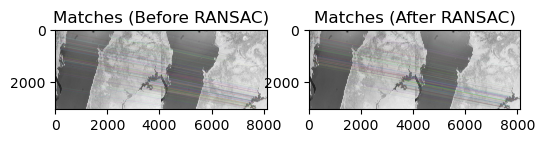

In [125]:
# Load and preprocess images
img1 = preprocess_image(REFFERENCE_IMAGE_PATH, scale_factor=1.0)
img2 = preprocess_image(TRANSLATED_IMAGE_PATH, scale_factor=1.0)

# Detect SIFT keypoints and descriptors
keypoints1, descriptors1 = SIFT_keypoints(img1)
keypoints2, descriptors2 = SIFT_keypoints(img2)

# Match keypoints
matches = match_keypoints(descriptors1, descriptors2)

# Remove outliers using RANSAC and get displacement vectors
inliers, displacement_vectors = remove_outliers_ransac(keypoints1, keypoints2, matches, img1, img2)

# Draw matches with and without outliers
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, inliers, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_matches_no_outliers = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# print number of matches
print(f"Number of matches: {len(matches)}")
print(f"Number of inliers: {len(inliers)}")

# Display images (in dedicated window)
#%matplotlib qt

plt.figure(figsize=(6, 12))
plt.subplot(1, 2, 1)
plt.imshow(img_matches_no_outliers)
plt.title('Matches (Before RANSAC)')


plt.subplot(1, 2, 2)
plt.imshow(img_matches)
plt.title('Matches (After RANSAC)')


print(f"Displacement Vectors: {displacement_vectors}")

### Compute final displacement vector:
    - Combine homography translation (RANSAC) and fine-tuned translation (Phase Correlation)

In [73]:
def draw_matches(image1, keypoints1, image2, keypoints2, matches):
    """
    Draw matches between two images.
    """
    image_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None)
    return image_matches

def draw_keypoints(image, keypoints):
    """
    Draw keypoints on an image.
    """
    image_keypoints = cv2.drawKeypoints(image, keypoints, None)
    return image_keypoints

def draw_inliers(image1, keypoints1, image2, keypoints2, inliers):
    """
    Draw inliers between two images.
    """
    image_inliers = cv2.drawMatches(image1, keypoints1, image2, keypoints2, inliers, None)
    return image_inliers

def main():
    keypoints1 = detect_harris_corners(reference_image_gray)
    keypoints2 = detect_harris_corners(translated_image_gray)
    keypoints1, descriptors1 = SIFT_keypoints(reference_image_gray)
    keypoints2, descriptors2 = SIFT_keypoints(translated_image_gray)
    matches = match_keypoints(descriptors1, descriptors2)
    inliers, displacement_vectors = remove_outliers_ransac(keypoints1, keypoints2, matches, reference_image_gray, translated_image_gray)

    # calculate displacement using phase correlation and inliers
    

    image_matches = draw_matches(reference_image_gray, keypoints1, translated_image_gray, keypoints2, matches)
    image_inliers = draw_inliers(reference_image_gray, keypoints1, translated_image_gray, keypoints2, inliers)
    image_keypoints1 = draw_keypoints(reference_image_gray, keypoints1)
    image_keypoints2 = draw_keypoints(translated_image_gray, keypoints2)
    
    print(f"Displacement: {displacement}")
    
    plt.figure(figsize=(20, 10))
    plt.subplot(231), plt.imshow(reference_image_gray, cmap='gray'), plt.title('Reference Image')
    plt.subplot(232), plt.imshow(translated_image_gray, cmap='gray'), plt.title('Translated Image')
    plt.subplot(233), plt.imshow(image_matches), plt.title('Matches')
    plt.subplot(234), plt.imshow(image_inliers), plt.title('Inliers')
    plt.subplot(235), plt.imshow(image_keypoints1), plt.title('Reference Image Keypoints')
    plt.subplot(236), plt.imshow(image_keypoints2), plt.title('Translated Image Keypoints')
    plt.show()

reference_image_gray = preprocess_image(REFFERENCE_IMAGE_PATH, SCALE_FACTOR)
translated_image_gray = preprocess_image(TRANSLATED_IMAGE_PATH, SCALE_FACTOR)

main()

[[ 1.00000000e+00 -2.35971333e-21  2.80210610e-21 ...  1.05294311e-20
  -1.61950493e-20  2.08219343e-21]
 [ 8.25090696e-21  1.86451877e-20 -1.32681201e-20 ...  1.85769477e-20
   1.92523173e-21  1.21659652e-20]
 [ 2.32264872e-21  2.59951944e-20  1.40560037e-21 ... -1.35086352e-20
  -1.02116520e-20  8.75785062e-21]
 ...
 [-4.57186906e-21 -4.90450007e-21 -3.17132118e-21 ... -9.15799977e-21
  -1.79089611e-22 -7.82837502e-21]
 [-2.32264872e-21  2.41521062e-20 -2.23182256e-20 ... -1.62682324e-20
  -6.76094752e-21  8.67423888e-22]
 [-8.25090696e-21  2.74666477e-20 -1.77286157e-20 ...  8.83680935e-23
   1.10198499e-20  4.32979656e-21]]
Global Translation (Phase Correlation): dx=0, dy=0
Displacement: [  36.1786759  -411.22903106]
